## Credit Card Fraud Detection

Author: Naphat Piphattanakarn

### Objectives
In this notebook, I will built and evaluate a variety of predictive models to detect credit card fraud transactions.

### Dataset Information
The dataset used here is from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud which contains transactions made by credit cards in September 2013 by European cardholders.

There are 30 features as follows:
 - V1 - V28: these are the result of a PCA transformation due to confidentiality issues
 - Time: the seconds elapsed between each transaction and the first transaction in the dataset
 - Amount: transaction amount
 - class: the label which takes value 1 in case of fraud and 0 otherwise

### Data Preparation

Let's import all the required packages and the dataset itself

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import pickle

from skopt import BayesSearchCV
from skopt.space.space import Real, Integer, Categorical

import imblearn

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('fraud_data.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# change all column names to lower case
df.columns = [col.lower() for col in df.columns]
df.describe()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Notice that v1 to v28 features are the result of PCA with mean zero and decreasing standard deviation.

### Exploratory Data Analysis

Next let's check how much imbalanced the data set is.

In [7]:
case_count = df['class'].value_counts()
print(case_count)
print(f'Fraud cases are only {case_count[1]*100/df.shape[0]:.2f}% of the entire dataset')

0    284315
1       492
Name: class, dtype: int64
Fraud cases are only 0.17% of the entire dataset


<AxesSubplot: ylabel='Frequency'>

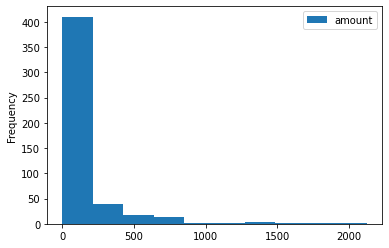

In [70]:
df.loc[df['class'] == 1, ['amount']].plot.hist()

<AxesSubplot: ylabel='Frequency'>

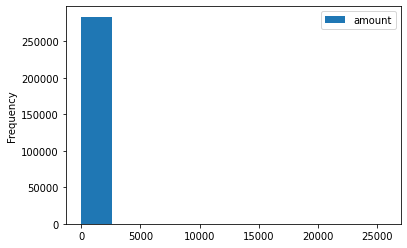

In [71]:
df.loc[df['class'] == 0, ['amount']].plot.hist()

<AxesSubplot: >

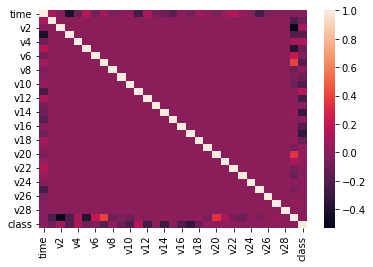

In [17]:
sns.heatmap(df.corr())

There is no obvious correlation (linear relationship) between any features in the data set.

### Model Training and Evaluation
Although the data is extremely imbalanced, I will start with using it to train the models as is. In the later section I will utilize techniques such as threshold-moving, cost-sensitive learning, and resampling to see how much performance increase they could give.

In [4]:
# Prepare train and test datasets
X = df.drop(columns=['time', 'class'])
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

First let's define a helper function for training a model. This function will also perform hyperparameter tuning using bayesian optimization as well. Here I will use f1 as a scoring metric for cross validation.

In [100]:
def train_model(model, model_name, param_grid, cv_scoring='f1', show_cv_result=True,
                X_train=X_train, y_train=y_train, cv_type=GridSearchCV, fit_params=None, 
                return_fitted=True):
    """Train the model and perform hyperparameter tuning for a specific estimator
    
    Args:
        model: sklearn's estimator instance
        model_name: string for estimator name
        param_grid: dictionary containing hyperparameter space for tuning
        cv_scoring (optional): metric to compare during cv; default to f1
        show_cv_result (optional): show cv result of each hyperparameter combination; default to True

    Return:
        model trained with best parameters 

    """

    preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['amount'])],
        remainder='passthrough'
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (model_name, model)
    ])

    search = cv_type(pipeline, 
                     param_grid,
                     n_jobs=-1,
                     scoring=cv_scoring,
                     fit_params=fit_params,
                     verbose=0)

    search.fit(X_train, y_train)

    print(f'Best {cv_scoring}: {search.best_score_} with params {search.best_params_}')

    if show_cv_result:
        cv_df = pd.concat([
            pd.DataFrame({f'mean_{cv_scoring}': search.cv_results_['mean_test_score'],
                        'stdev': search.cv_results_['std_test_score']}),
            pd.DataFrame(search.cv_results_['params'])
        ], axis=1)
        print(f'Top 5 average {cv_scoring} score:')
        display(HTML(cv_df.sort_values(f'mean_{cv_scoring}', ascending=False).head().to_html()))

    # Train model with all training data using best params

    if return_fitted:
        best_model = search.best_estimator_.fit(X_train, y_train)
    else:
        best_model = search.best_estimator_

    return best_model


Next let's define a function for model evaluation. As I'm using f1 as a scoring metric, I will optimize threshold (threshold moving) to get the best f1 from the model here. As this is a very imbalanced dataset, I will use confusion matrix and precision-recall curve to evaluate the performance as well.

In [5]:
def evaluate_model(model):
    """Evaluate the performance of the model with test set using ROC curve, Prec-Recall curve
    and classification report by setting threshold to optimize f1 in this case
    
    """

    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.predict(X_test)
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * recall * precision / (recall + precision)
    opt_idx =  np.argmax(f1_scores)
    best_thresh = thresholds[opt_idx]
    print(f'Best threshold to maximize f1 is {best_thresh: .4f}')

    y_pred = (y_proba > best_thresh).astype(int)
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    _, ax = plt.subplots()
    ax.plot(recall[:-1], precision[:-1])
    circle = plt.Circle((recall[opt_idx], precision[opt_idx]), 0.05, color='red', fill=False)
    ax.add_artist(circle)
    plt.title('Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()


### Logistic Regression
For classification task, logistic regression is a linear model that is simple, easy to train and make inference, so let's first try this model.

In [35]:
# Parameter space to perform hyperparameter tuning
param_grid = {
    'logistic_regression__class_weight': Categorical(['auto', 'balanced']),
    'logistic_regression__C': Real(0.01, 100, prior='log-uniform'),
    'logistic_regression__penalty': Categorical(['l2']),
    'logistic_regression__solver': Categorical(['newton-cg', 'lbfgs', 'liblinear'])
}

lr_clf = train_model(model=LogisticRegression(),
                     model_name='logistic_regression',
                     param_grid=param_grid,
                     cv_type=BayesSearchCV)

Best f1: 0.7338382198851061 with params OrderedDict([('logistic_regression__C', 0.042563031992546754), ('logistic_regression__penalty', 'l2'), ('logistic_regression__solver', 'newton-cg')])


,mean_f1,stdev,logistic_regression__C,logistic_regression__penalty,logistic_regression__solver
0,0.730329,0.022236,9.703052,l2,liblinear
1,0.730329,0.022236,3.431623,l2,liblinear
2,0.725509,0.030285,0.060790,l2,liblinear
3,0.730329,0.022236,4.672832,l2,liblinear
4,0.732164,0.024924,92.885852,l2,lbfgs
5,0.732164,0.024924,28.387873,l2,liblinear
6,0.732164,0.024924,28.264544,l2,newton-cg
7,0.730329,0.022236,0.926647,l2,newton-cg
8,0.731614,0.025727,0.643691,l2,liblinear
9,0.729649,0.024324,1.344067,l2,liblinear


Here the best cross-validated average f1 is 0.73 after hyperparameter tuning. Note that this might not be the optimal f1. 

Next let's test it with the test set and adjust the threshold to optimize f1.

Best threshold to maximize f1 is  0.0860
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.82      0.75        98

    accuracy                           1.00     56962
   macro avg       0.85      0.91      0.88     56962
weighted avg       1.00      1.00      1.00     56962



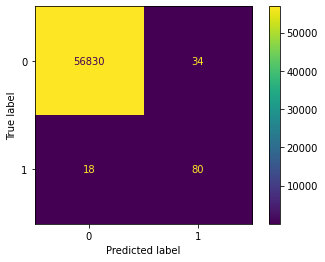

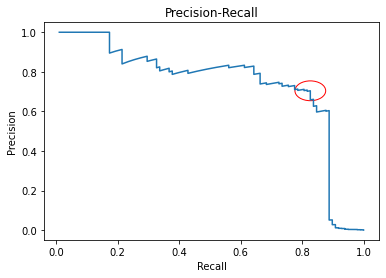

In [36]:
evaluate_model(lr_clf)

The optimal f1 with the test set is 0.75 with precision 0.70 and recall 0.82.

In [61]:
# Save model
f_name = 'models\logistic_regression.pkl'
pickle.dump(lr_clf, open(f_name, 'wb'))

### Support Vector Machine

Next let's try using support vector machine. I will go through the same process as above.

In [38]:
param_grid = {
    'support_vector_machine__C': Real(0.1, 100, prior='log-uniform'), 
    'support_vector_machine__gamma': Real(0.001, 1, prior='log-uniform'),
    'support_vector_machine__kernel': Categorical(['rbf', 'poly', 'sigmoid'])
}

svm_clf = train_model(model=SVC(),
                     model_name='support_vector_machine',
                     param_grid=param_grid,
                     cv_type=BayesSearchCV)

Best f1: 0.8522566798935609 with params OrderedDict([('support_vector_machine__C', 43.31135366722287), ('support_vector_machine__gamma', 0.009613507659233704), ('support_vector_machine__kernel', 'rbf')])


,mean_f1,stdev,support_vector_machine__C,support_vector_machine__gamma,support_vector_machine__kernel
0,0.844994,0.045286,47.431037,0.014007,rbf
1,0.313934,0.020141,0.113463,0.048679,sigmoid
2,0.747440,0.034706,0.190653,0.011738,rbf
3,0.337988,0.040448,27.231548,0.174809,rbf
4,0.835203,0.033783,23.260810,0.021581,rbf
5,0.781146,0.030998,29.868734,0.002781,poly
6,0.378440,0.039957,10.366821,0.018567,sigmoid
7,0.849332,0.041596,23.014068,0.008626,rbf
8,0.561738,0.048743,2.849128,0.374113,poly
9,0.655901,0.036705,7.536944,0.001072,poly


The best cross-validated average f1 is 0.85 after hyperparameter tuning.

In [67]:
# Set param to predict probability to be able to adjust threshold
svm_clf_prob = svm_clf.set_params(support_vector_machine__probability=True)
svm_clf_prob.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['amount'])])),
                ('support_vector_machine',
                 SVC(C=43.31135366722287, gamma=0.009613507659233704,
                     probability=True))])

Best threshold to maximize f1 is  0.1915
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



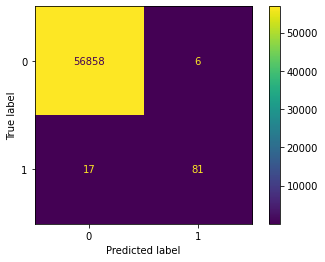

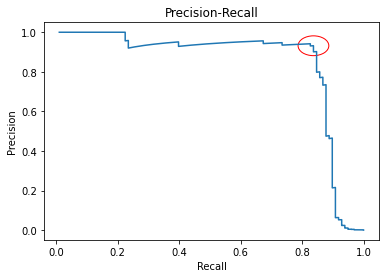

In [68]:
evaluate_model(svm_clf_prob)

The optimal f1 with the test set after adjusting the threshold is 0.88 with precision 0.93 and recall 0.83

In [69]:
# Save model
f_name = 'models\svm.pkl'
pickle.dump(svm_clf_prob, open(f_name, 'wb'))

### Randomforest Classifier

Next let's try a tree based ensemble model, randomforest classifier. Here I will try different class_weight parameter of the models for cost sensitive learning. 

In [101]:
param_grid = {
    'randomforest__class_weight': Categorical([None, 'balanced', 'balanced_subsample']),    # Different values to perform cost-sensitive learning e.g. it will cost more fo errors of minority class
    'randomforest__max_depth':Integer(3, 20),
    'randomforest__min_samples_split': Real(0.01, 1, prior='log-uniform'),
    'randomforest__max_features': Integer(10, X_train.shape[1]),
    "randomforest__n_estimators":Integer(100, 200)
    }

rf_clf = train_model(RandomForestClassifier(random_state=42),
                     'randomforest',
                     param_grid=[(param_grid, 20)],
                     cv_type=BayesSearchCV)

Best f1: 0.7631502407742081 with params OrderedDict([('randomforest__class_weight', None), ('randomforest__max_depth', 6), ('randomforest__max_features', 11), ('randomforest__min_samples_split', 0.48072417124579875), ('randomforest__n_estimators', 176)])
Top 5 average f1 score:


,mean_f1,stdev,randomforest__class_weight,randomforest__max_depth,randomforest__max_features,randomforest__min_samples_split,randomforest__n_estimators
9,0.763150,0.027073,None,6,11,0.480724,176
12,0.761646,0.024458,None,7,10,0.395977,182
14,0.761313,0.022248,None,20,22,0.061160,132
15,0.760313,0.023879,None,10,23,0.013711,121
1,0.760294,0.021266,None,11,21,0.014844,126


The best cross-validated average f1 is 0.76 after hyperparameter tuning. Interestingly, the best class_weight parameter is None. Meaning that

Best threshold to maximize f1 is  0.6352
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.71      0.75        98

    accuracy                           1.00     56962
   macro avg       0.90      0.86      0.88     56962
weighted avg       1.00      1.00      1.00     56962



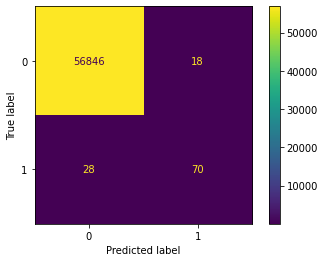

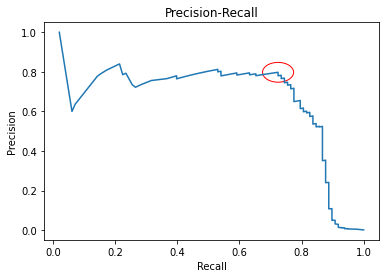

In [102]:
evaluate_model(rf_clf)

The optimal f1 with the test set after adjusting the threshold is 0.75 with precision 0.80 and recall 0.71

In [109]:
# Save model
f_name = 'models/rf.pkl'
pickle.dump(rf_clf, open(f_name, 'wb'))

#### LightGBM

Another tree-based ensemble model - LightGBM

Here I will split the training set into 2 part as training and validation as I want to use the validation part to perform early stopping.

In [6]:
# Split train set into train and validation sets
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

In [111]:
param_space =  {
    'lgbm__learning_rate': Real(0.001, 10, prior='log-uniform'),
    'lgbm__num_leaves': Integer(8, 256),
    'lgbm__max_depth': Integer(3, 16),
    'lgbm__min_child_samples': Integer(5, 300, prior='log-uniform'),
    'lgbm__n_estimators': Integer(100, 10000, prior='log-uniform'),
    'lgbm__subsample': Real(0.5, 1),
    'lgbm__colsample_bytree': Real(0.5, 1),
    'lgbm__reg_alpha': Real(0, 100),
    'lgbm__reg_lambda': Real(0, 100)
}

fit_params = {
    'lgbm__eval_set':[(X_val, y_val)],
    'lgbm__call_backs':[lgb.early_stopping(25)]
}

lgbm_clf = train_model(
    lgb.LGBMClassifier(random_state=42),
    'lgbm',
    param_grid=[(param_space, 30)],
    X_train=X_train_2,
    y_train=y_train_2,
    cv_type=BayesSearchCV,
    fit_params=fit_params
)

Best f1: 0.8624744303124722 with params OrderedDict([('lgbm__colsample_bytree', 0.8357795297327033), ('lgbm__learning_rate', 0.008107304659240111), ('lgbm__max_depth', 4), ('lgbm__min_child_samples', 5), ('lgbm__n_estimators', 10000), ('lgbm__num_leaves', 52), ('lgbm__reg_alpha', 0.0), ('lgbm__reg_lambda', 67.41043923282376), ('lgbm__subsample', 0.8178384589968457)])
Top 5 average f1 score:


,mean_f1,stdev,lgbm__colsample_bytree,lgbm__learning_rate,lgbm__max_depth,lgbm__min_child_samples,lgbm__n_estimators,lgbm__num_leaves,lgbm__reg_alpha,lgbm__reg_lambda,lgbm__subsample
22,0.862474,0.034718,0.835780,0.008107,4,5,10000,52,0.00000,67.410439,0.817838
21,0.858929,0.027751,0.832753,0.139287,9,300,1544,256,0.00000,100.000000,0.510118
19,0.857568,0.025892,0.632295,0.167076,5,21,2146,246,0.00000,75.328048,0.652003
25,0.857475,0.029793,0.770509,0.010097,5,5,10000,54,0.00000,59.269495,0.723214
16,0.856133,0.031214,0.605473,0.110785,4,22,3280,256,1.71457,84.422706,0.649062


The best cross-validated average f1 is 0.86 after hyperparameter tuning.

Best threshold to maximize f1 is  0.4855
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.79      0.86        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



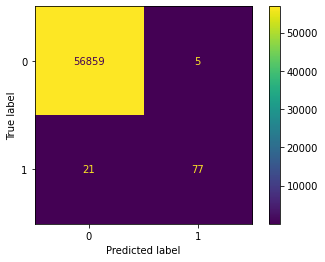

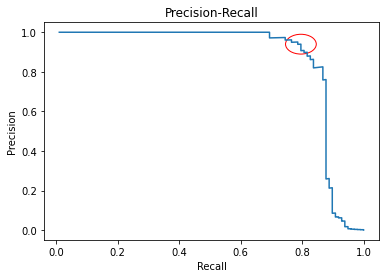

In [112]:
evaluate_model(lgbm_clf)

The optimal f1 with the test set after adjusting the threshold is 0.86 with precision 0.94 and recall 0.79

In [113]:
# Save model
f_name = 'models/lgbm.pkl'
pickle.dump(lgbm_clf, open(f_name, 'wb'))

#### Neaural Network

Here I will also try a feedforward neaural network as well, but without hyper parameter tuning.

In [8]:
def create_model():
    # Define the input shape
    input_shape = (X_train.shape[1],)

    # Create the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Add the first hidden layer
    layer = tf.keras.layers.BatchNormalization()(inputs)
    layer = tf.keras.layers.Dense(units=128, activation='relu')(layer)

    layer = tf.keras.layers.Dropout(rate=0.2)(layer)
    # Add more hidden layers as needed
    layer = tf.keras.layers.Dense(units=128, activation='relu')(layer)

    # Add the output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(layer)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    loss = tf.keras.losses.BinaryFocalCrossentropy()

    model.compile(loss=loss, 
                optimizer='adam',
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


# Cast to numpy arrays
X_train_2_np = X_train_2.values
y_train_2_np = y_train_2.values
X_val_np = X_val.values
y_val_np = y_val.values

model = KerasClassifier(build_fn=create_model, epochs=8, batch_size=64, verbose=0)
# evaluate using 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

fit_params = {
    'validation_data': (X_val_np, y_val_np),
    'callbacks': [early_stopping]
}

# Evaluate using cross validation
results = cross_val_score(model, X_train_2_np, y_train_2_np, scoring='f1', 
                          cv=kfold, fit_params=fit_params, n_jobs=-1, verbose=1)


C:\Users\Naphat\AppData\Local\Temp\ipykernel_27040\1456909687.py:37: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=8, batch_size=64, verbose=0)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 344.5min remaining: 516.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 354.2min finished


In [11]:
print(f'The cross-validated f1 score is {results.mean()} with std of {results.std()}')

The cross-validated f1 score is 0.8133757848618529 with std of 0.03697007777717454


In [12]:
nn_model = create_model()
nn_model.fit(X_train_2_np, y_train_2_np, batch_size=64, epochs=8, validation_data=(X_val_np, y_val_np), callbacks=[early_stopping])

Epoch 1/8
2849/2849 [==============================] - 35s 11ms/step - loss: 0.0020 - precision: 0.6012 - recall: 0.6508 - val_loss: 0.0020 - val_precision: 0.8333 - val_recall: 0.7595
Epoch 2/8
2849/2849 [==============================] - 33s 12ms/step - loss: 0.0011 - precision: 0.8694 - recall: 0.7397 - val_loss: 0.0013 - val_precision: 0.8429 - val_recall: 0.7468
Epoch 3/8
2849/2849 [==============================] - 35s 12ms/step - loss: 9.1637e-04 - precision: 0.8736 - recall: 0.7683 - val_loss: 0.0014 - val_precision: 0.8525 - val_recall: 0.6582
Epoch 4/8
2849/2849 [==============================] - 34s 12ms/step - loss: 8.5193e-04 - precision: 0.8801 - recall: 0.7460 - val_loss: 0.0016 - val_precision: 0.8676 - val_recall: 0.7468
Epoch 5/8
2849/2849 [==============================] - 34s 12ms/step - loss: 8.2503e-04 - precision: 0.8832 - recall: 0.7683 - val_loss: 0.0014 - val_precision: 0.8594 - val_recall: 0.6962


1781/1781 [==============================] - 5s 3ms/step
Best threshold to maximize f1 is  0.4764
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.81      0.82        98

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962



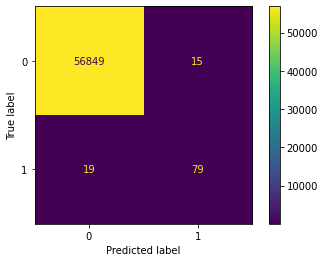

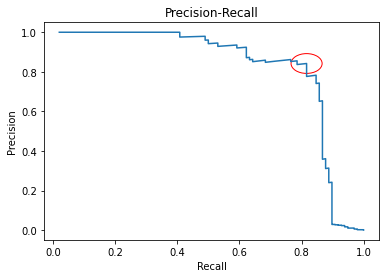

In [13]:
evaluate_model(nn_model)

In [14]:
# Save model
f_name = 'models/nn.pkl'
pickle.dump(nn_model, open(f_name, 'wb'))

INFO:tensorflow:Assets written to: ram://e896fbc9-e6b2-4b92-9ecd-29e272efb8ae/assets


### Resampling Techniques

Considered the best CV average F1 score from each model and training time, Lightgbm seems to perform the best and took less amount of time to test and make inference. 
In the next part I will try to use resampling method to deal with the unbalanced data set to see if the performance can be improved.

In [7]:
param_space =  {
    'lgbm__learning_rate': Real(0.001, 10, prior='log-uniform'),
    'lgbm__num_leaves': Integer(8, 256),
    'lgbm__max_depth': Integer(3, 16),
    'lgbm__min_child_samples': Integer(5, 300, prior='log-uniform'),
    'lgbm__n_estimators': Integer(100, 10000, prior='log-uniform'),
    'lgbm__subsample': Real(0.5, 1),
    'lgbm__colsample_bytree': Real(0.5, 1),
    'lgbm__reg_alpha': Real(0, 100),
    'lgbm__reg_lambda': Real(0, 100)
}

preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), ['amount'])],
    remainder='passthrough'
)

pipeline = imblearn.pipeline.Pipeline([
    ('over', imblearn.over_sampling.SMOTE()),
    ('under', imblearn.under_sampling.RandomUnderSampler()),
    ('preprocessor', preprocessor),
    ('lgbm', lgb.LGBMClassifier(random_state=42))
])

fit_params = {
    'lgbm__eval_set':[(X_val, y_val)],
    'lgbm__call_backs':[lgb.early_stopping(25)]
}


search = BayesSearchCV(pipeline, 
                    [(param_space, 30)],
                    n_jobs=-1,
                    scoring='f1',
                    fit_params=fit_params,
                    verbose=0)

search.fit(X_train_2, y_train_2)

print(f'Best f1: {search.best_score_} with params {search.best_params_}')

Best f1: 0.8527588772937387 with params OrderedDict([('lgbm__colsample_bytree', 0.5), ('lgbm__learning_rate', 0.05788766076189242), ('lgbm__max_depth', 16), ('lgbm__min_child_samples', 300), ('lgbm__n_estimators', 10000), ('lgbm__num_leaves', 72), ('lgbm__reg_alpha', 0.0), ('lgbm__reg_lambda', 0.0), ('lgbm__subsample', 0.94067351128186)])


Here the cross validated f1 score is 0.853 which dropped a little from before using resampling techniques. However, if we look at the tuned hyperparameters some of them are at the border values of the parameter space, so might need to expand the parameter space more to be able to fine tune the performance better.

In [9]:
lgbm_imlearned = search.best_estimator_
lgbm_imlearned.fit(X_train, y_train)

Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['amount'])])),
                ('lgbm',
                 LGBMClassifier(colsample_bytree=0.5,
                                learning_rate=0.05788766076189242, max_depth=16,
                                min_child_samples=300, n_estimators=10000,
                                num_leaves=72, random_state=42,
                                subsample=0.94067351128186))])

Let's try evaluate it with the test set.

Best threshold to maximize f1 is  0.9992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



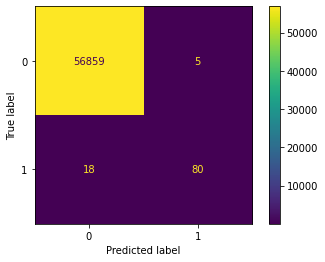

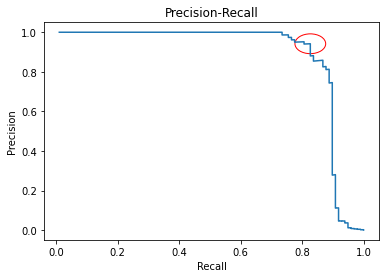

In [10]:
evaluate_model(lgbm_imlearned)

The f1 score here is a little better than the Lightgbm classifier without resampling. However, this might be just pure luck. It's always better to compare performance of 2 model using cross validation instead of using only 1 test set.

In [11]:
# Save model
f_name = 'models/lgbm_imlearned.pkl'
pickle.dump(lgbm_imlearned, open(f_name, 'wb'))

### Summary
We now see the performance of different models on this fraud detection task some of them such as Lightgbm and SVM showed very promising results. Even with the imbalanced nature of the dataset some models also perform great already by just adjusting the threshold (threshold moving), which is a useful step to deal with imbalanced problem. We also tried using over and undersampling to help with that problem a little more. However, over and under sampling also have some parameters to further adjust to improve the model. 

To choose the best model in the realworld, there are a few key points apart from the performance like precision, recall, or f1.

1. Inference time: 
There might be a requirement for the amount of time used to make inference to be faster than some number. This make senses since it's supposed to be used with real-time transaction data to detect fraud within a matter of seconds. It also depends on the system or hardware the model has to run on.

2. Training time: 
This might not be as important as the inference time since if the distribution of the data (in the real world) does not change we don't need to frequently retrain the model. Still this could be something to look at if retraining is required often.

3. Misclassification cost: 
This is a very, if not the most, important factor to consider, since we want the model to detect fraud to prevent cost of fradulent transaction. Misclassifying fradulent transactions as good transactions (false negative) will cost at least the amount of the transactions plus the hidden cost of customer disatisfaction and reputation decreasing of the company. Misclassifying good transactions and fradulent (false positive) will not incur any cost instantly but again will have the hidden cost of customer disatisfaction. It's usually hard to find actual cost especially for the latter case. In practice, we can come up with some number for each case of misclassification to help choose the model that give the lowest cost. We can also adjust the threshold to get the lowest cost from each model and compare instead of using f1 as we did here.